# Detection Error Tradeoff 

In [1]:
import math
import operator
from pathlib import Path

from ipywidgets import fixed, interact
import ipywidgets as widgets
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import describe, gaussian_kde
import seaborn as sns

import sys
sys.path.insert(0, '../../utils')


from DET_utils.DET import DET
from DET_utils.DET_plots import *



mated_colour = "green"
mated_label = "Mated scores"
nonmated_colour = "red"
nonmated_label = "Non-mated scores"

figure_size = (12,6)
alpha_shade = 0.25
alpha_fill = 1.0
linewidth = 2
legend_loc = "upper left"
legend_anchor = (1.0, 1.02)
legend_cols = 1
legend_fontsize = 12
label_fontsize = 16

threshold_colour = "black"
threshold_style = "--"
round_digits = 5
sns.set(style="white", palette="muted", color_codes=True)
plt.rc("axes", axisbelow=True)

## Load mated and non-mated similarity scores 

In [2]:
mated_scores1 = np.load('../mated_sim_scores_child_final.npy')
nonmated_scores1 = np.load('../nonmated_sim_scores_child_final.npy')
scores_type1 = "similarity"

In [4]:
stats_system1_df = descriptive_statistics(mated_scores1, nonmated_scores1)
stats_system1_df.round(round_digits).style.hide_index()

/tmp/ipykernel_51455/3645691370.py:2: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  stats_system1_df.round(round_digits).style.hide_index()


Statistic,Mated,Non-mated
Observations,3732.000000,3321525.000000
Minimum,0.190430,-0.375020
Maximum,0.989440,0.984690
Mean,0.635340,0.158550
St. Dev.,0.147900,0.131880
Skewness,-0.372080,0.204570
Ex. Kurtosis,-0.141960,-0.033340


# Plots

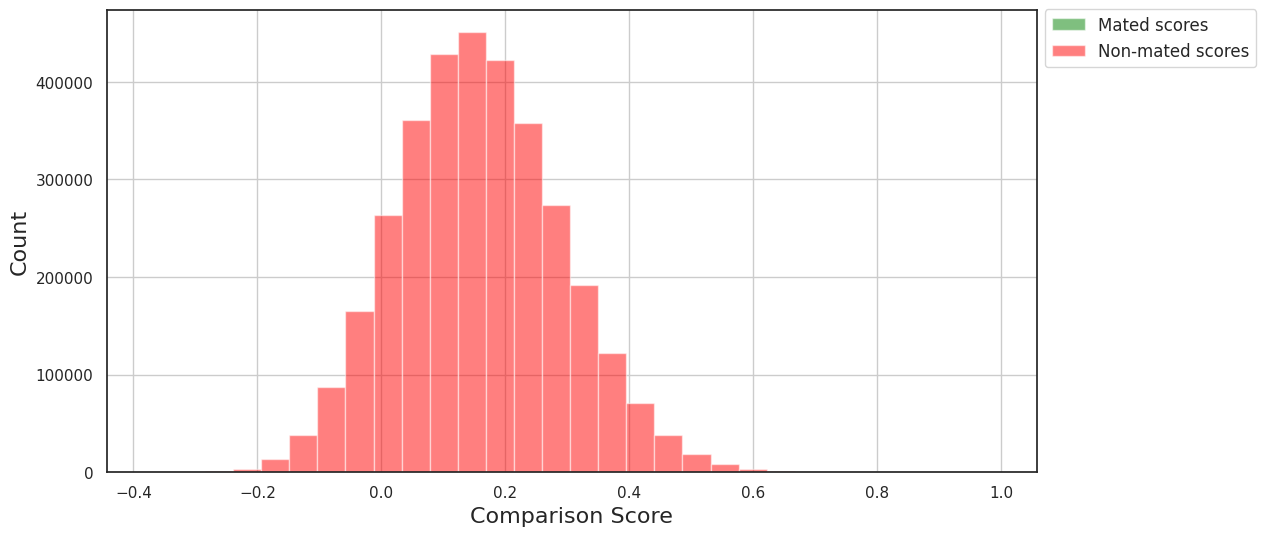

In [5]:

plot_histogram(mated_scores1, nonmated_scores1, normalise=False)

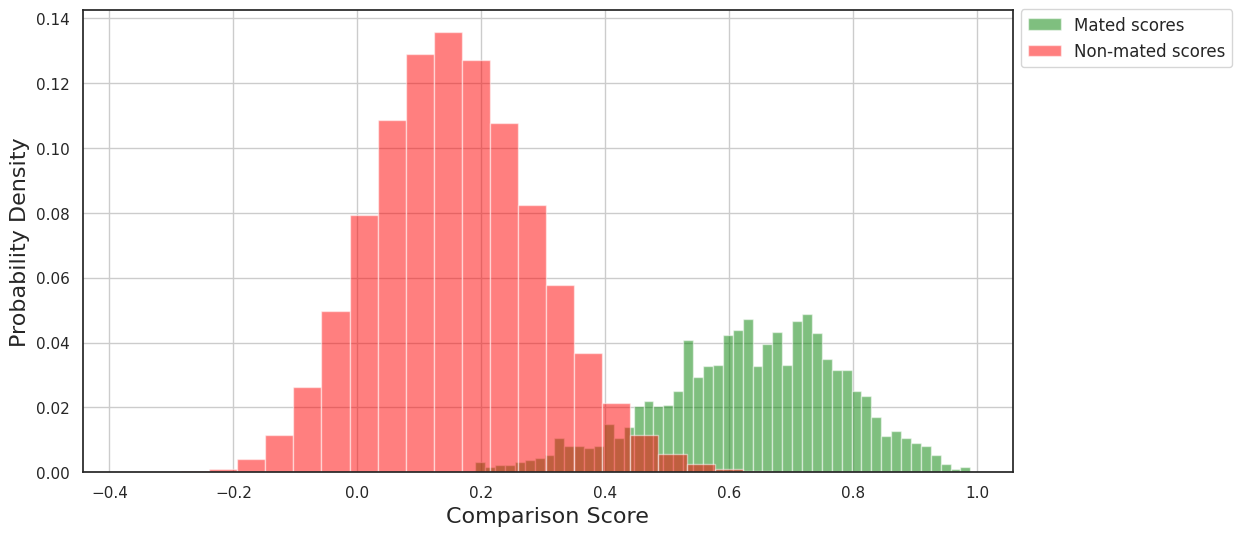

In [6]:
plot_histogram(mated_scores1, nonmated_scores1, normalise=True)

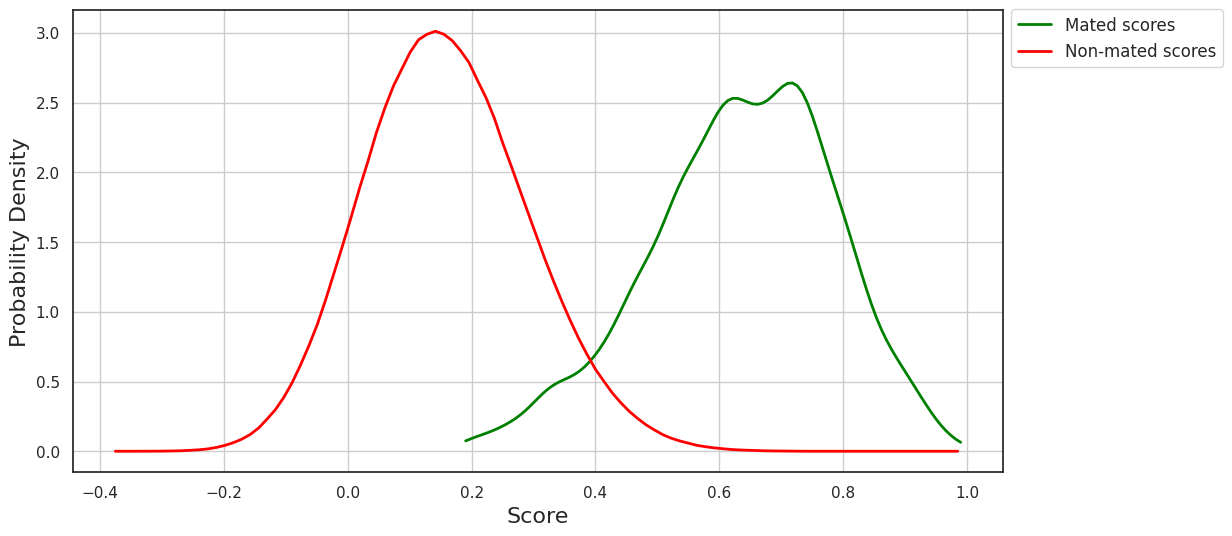

In [7]:
mated_kde, mated_pos, mated_min, mated_max = get_kde(mated_scores1)
nonmated_kde, nonmated_pos, nonmated_min, nonmated_max = get_kde(nonmated_scores1)
plt.figure(figsize=figure_size)
plt.plot(mated_pos, mated_kde(mated_pos), linewidth=linewidth, color=mated_colour, label=mated_label)
plt.plot(nonmated_pos, nonmated_kde(nonmated_pos), linewidth=linewidth, color=nonmated_colour, label=nonmated_label)
plt.xlabel("Score", size=label_fontsize)
plt.ylabel("Probability Density", size=label_fontsize)
plt.grid(True)
plt.legend(loc=legend_loc, bbox_to_anchor=legend_anchor, ncol=legend_cols, fontsize=legend_fontsize)
plt.show()